In [3]:
import geatpy as ea
import numpy as np
import pandas as pd
import time
import heapq
import json
import psycopg2
import psycopg2.extras
import warnings
import sys
import uuid
import datetime

In [4]:
"""
Check before submit
1. enable ReportStatus
2. enable OutputPackage
3. disable reading local data
"""
numLimit = 5 # maximum num of constraints in each condition
timeLimit = 600
threadLimit = 4
total_time = time.time()

if sys.version_info[0:2] != (3, 6):
    warnings.warn('Please use Python3.6', UserWarning)

def ReportStatus(msg, flag, queryID):
    """
    Print message and update status in biz_model.biz_fir_query_parameter_definition.
    """
    print("============================================================================================================================")
    print("Reporting issue:", msg)

def TestData(queryID):
    try:
        print('Parameters reading...')
        sqlParameter = "select python_json, id from biz_model.biz_fir_query_parameter_definition where id='{0}'".format(queryID)
        conn = psycopg2.connect(host = "10.18.35.245", port = "5432", dbname = "biz_model_prod", user = "bizmodeluser", password = "$2kBBx@@!!")
        paramInput = pd.read_sql(sqlParameter, conn)
        if paramInput.shape[0] == 0:
            raise Exception("No Valid Query Request is Found!")
        elif paramInput.shape[0] > 1:
            raise Exception("More than One Valid Query Requests are Found!")
        queryID = paramInput['id'][0]
        param = json.loads(paramInput['python_json'][0])
    except Exception as e:
        print("Loading Parameters from GreenPlum Failed!\n", e)
        exit(1)

    try:
        print('Data loading...')
        print('Query ID:', queryID)
        sqlInput = """
            select billing_status_fz as billing, unit_id_fz as unit_id, product, fleet_year_fz as fleet_year, contract_cust_id as customer, \
            contract_lease_type as contract, cost, nbv, age_x_ceu as weighted_age, query_id, ceu_fz as ceu, teu_fz as teu
            from biz_model.biz_ads_fir_pkg_data WHERE query_id='{0}'
        """.format(queryID) 
        data = pd.read_sql(sqlInput, conn)

        if data.shape[0] == 0:
            raise Exception("No Data Available!")
        print('Input data shape:', data.shape)
        print(param)
        conn.close()
    except Exception as e:
        print(e)
        ReportStatus("Loading Data from GreenPlum Failed!", 'F', queryID)
        exit(1)

    return queryID, param, data

# queryID, param, data = ConnectDatabase()
queryID = '8E1JnYCtNMxXNvjPhFBq8y'
queryID, param, data = TestData(queryID)

# print('Data reading...')
# data = pd.read_csv('./local_data.csv')
# print('Data loading...')
# with open("./parameterDemo2.json") as f:
#     param = json.load(f)
# queryID = "local_test_id"
# print(param)
# print(data.shape)

print("==============================================================")
print('Parameters parsing...')
try:
    if 'timeLimit' in param:
        timeLimit = param['timeLimit']
    # timeLimit = 1000
    print('time limit:', timeLimit)
    NbvCost = param['prefer']['nbvorCost']
    maxOrMin = param['prefer']['maxOrMin']

    fleetAgeLowBound = [None for _ in range(numLimit)]
    fleetAgeUpBound = [None for _ in range(numLimit)]
    fleetAgeLimit = [None for _ in range(numLimit)]
    fleetAgeGeq = [None for _ in range(numLimit)]
    weightedAgeLowBound = [None for _ in range(numLimit)]
    weightedAgeUpBound = [None for _ in range(numLimit)]
    weightedAgeLimit = [None for _ in range(numLimit)]
    weightedAgeGeq = [None for _ in range(numLimit)]
    lesseeType = [None for _ in range(numLimit)]
    lesseeLimit = [None for _ in range(numLimit)]
    lesseeGeq = [None for _ in range(numLimit)]
    productType = [None for _ in range(numLimit)]
    productLimit = [None for _ in range(numLimit)]
    productGeq = [None for _ in range(numLimit)]
    contractType = [None for _ in range(numLimit)]
    contractLimit = [None for _ in range(numLimit)]
    contractGeq = [None for _ in range(numLimit)]
    statusType = [None for _ in range(numLimit)]
    statusLimit = [None for _ in range(numLimit)]
    statusGeq = [None for _ in range(numLimit)]

    minTotalNbv = param['totalNBVFrom']
    maxTotalNbv = param['totalNBVTo']

    minTotalCost = param['totalCostFrom']
    maxTotalCost = param['totalCostTo']

    topLesseeLimit = [
        param['lessee']['topLessee']['top1']['percent'] / 100,
        param['lessee']['topLessee']['top2']['percent'] / 100,
        param['lessee']['topLessee']['top3']['percent'] / 100]
    topLesseeGeq = [
        param['lessee']['topLessee']['top1']['symbol'],
        param['lessee']['topLessee']['top2']['symbol'],
        param['lessee']['topLessee']['top3']['symbol']]
    fleetAgeAvgLimit = param['containersAge']['average']['averageContainersAge']
    fleetAgeAvgGeq = param['containersAge']['average']['symbol']
    fleetAgeBasis = param['containersAge']['basis']
    for i in range(len(param['containersAge']['list'])):
        fleetAgeLowBound[i] = param['containersAge']['list'][i]['containersAgeFrom']
        fleetAgeUpBound[i] = param['containersAge']['list'][i]['containersAgeTo']
        fleetAgeLimit[i] = param['containersAge']['list'][i]['percent'] / 100
        fleetAgeGeq[i] = param['containersAge']['list'][i]['symbol']

    weightedAgeAvgLimit = param['weightedAge']['average']['averageWeighedAge']
    weightedAgeAvgGeq = param['weightedAge']['average']['symbol']
    weightedAgeBasis = param['weightedAge']['basis']
    for i in range(len(param['weightedAge']['list'])):
        weightedAgeLowBound[i] = param['weightedAge']['list'][i]['weightedAgeFrom']
        weightedAgeUpBound[i] = param['weightedAge']['list'][i]['weightedAgeTo']
        weightedAgeLimit[i] = param['weightedAge']['list'][i]['percent'] / 100
        weightedAgeGeq[i] = param['weightedAge']['list'][i]['symbol']

    lesseeBasis = param['lessee']['basis']
    for i in range(len(param['lessee']['list'])):
        lesseeType[i] = param['lessee']['list'][i]['lessee']
        lesseeLimit[i] = param['lessee']['list'][i]['percent'] / 100
        lesseeGeq[i] = param['lessee']['list'][i]['symbol']

    statusBasis = param['status']['basis']
    for i in range(len(param['status']['list'])):
        statusType[i] = param['status']['list'][i]['statusType']
        statusLimit[i] = param['status']['list'][i]['percent'] / 100
        statusGeq[i] = param['status']['list'][i]['symbol']

    productBasis = param['product']['basis']
    for i in range(len(param['product']['list'])):
        productType[i] = param['product']['list'][i]['productType']
        productLimit[i] = param['product']['list'][i]['percent'] / 100
        productGeq[i] = param['product']['list'][i]['symbol']

    contractBasis = param['contractType']['basis']
    for i in range(len(param['contractType']['list'])):
        contractType[i] = param['contractType']['list'][i]['contractType']
        contractLimit[i] = param['contractType']['list'][i]['percent'] / 100
        contractGeq[i] = param['contractType']['list'][i]['symbol']
except Exception as e:
    print(e)
    msg = 'Parsing Paramters Failed! ' + str(e)
    ReportStatus(msg, 'F', queryID)
    exit(1)

print("==============================================================")
print('Data processing...')
try:
    # Billing Status
    data['OnHireStatus'] = data['billing'].apply(lambda x: 1 if x=='ON' else 0)
    data['OffHireStatus'] = data['billing'].apply(lambda x: 1 if x=='OF' else 0)
    data['NoneStatus'] = data['billing'].apply(lambda x: 1 if (x!='ON' and x!='OF') else 0)
    # ONE HOT -- all lessee
    for lesseeName in data['customer'].value_counts().index:
        data[lesseeName] = data['customer'].apply(lambda x: 1 if x==lesseeName else 0)
    for i in range(numLimit):
        # Container Age
        if fleetAgeLimit[i]:
            column_name = 'FleetAge{0}'.format(i)
            data[column_name] = data['fleet_year'].apply(lambda x: 1 if fleetAgeLowBound[i]<=x<=fleetAgeUpBound[i] else 0)
        # Weighted Age
        if weightedAgeLimit[i]:
            column_name = 'WeightedAge{0}'.format(i)
            data[column_name] = data['weighted_age'].apply(lambda x: 1 if weightedAgeLowBound[i]<=x<=weightedAgeUpBound[i] else 0)
        # Product Type
        if productLimit[i]:
            column_name = 'ProductType{0}'.format(i)
            data[column_name] = data['product'].apply(lambda x: 1 if x in productType[i] else 0)
        # Contract Type
        if contractLimit[i]:
            column_name = 'ContractType{0}'.format(i)
            data[column_name] = data['contract'].apply(lambda x: 1 if x in contractType[i] else 0)

    # convert data to numpy
    nbv = data['nbv'].to_numpy()
    cost = data['cost'].to_numpy()
    ceu = data['ceu'].to_numpy()
    teu = data['teu'].to_numpy()
    fleetAgeAvg = data['fleet_year'].to_numpy()
    weightedAgeAvg = data['weighted_age'].to_numpy()
    onHireStatus = data['OnHireStatus'].to_numpy()
    offHireStatus = data['OffHireStatus'].to_numpy()
    noneHireStatus = data['NoneStatus'].to_numpy()
    lesseeOneHot = {lesseeName: data[lesseeName].to_numpy() for lesseeName in data['customer'].value_counts().index}
    fleetAge = []
    weightedAge = []
    product = []
    contract = []
    for i in range(numLimit):
        fleetAge.append(data['FleetAge{0}'.format(i)].to_numpy() if fleetAgeLimit[i] else None)
        weightedAge.append(data['WeightedAge{0}'.format(i)].to_numpy() if weightedAgeLimit[i] else None)
        product.append(data['ProductType{0}'.format(i)].to_numpy() if productLimit[i] else None)
        contract.append(data['ContractType{0}'.format(i)].to_numpy() if contractLimit[i] else None)
    basis = {}
    basis['nbv'] = nbv
    basis['ceu'] = ceu
    basis['teu'] = teu
    basis['cost'] = cost
    hireStatus = {}
    hireStatus['ON'] = onHireStatus
    hireStatus['OF'] = offHireStatus
    hireStatus['None'] = noneHireStatus 
except Exception as e:
    print(e)
    msg = 'Processing Data Failed!' + str(e)
    ReportStatus(msg, 'F', queryID)
    exit(1)


Parameters reading...
Data loading...
Query ID: 8E1JnYCtNMxXNvjPhFBq8y
Input data shape: (140808, 12)
{'prefer': {'maxOrMin': 0, 'nbvorCost': 0}, 'timeLimit': 2000, 'totalNBVFrom': 130000000.0, 'totalNBVTo': 230000000.0, 'totalCostFrom': None, 'totalCostTo': 810477698.62, 'containersAge': {'basis': None, 'average': {'symbol': None, 'averageContainersAge': None}, 'list': []}, 'weightedAge': {'basis': None, 'average': {'symbol': None, 'averageWeighedAge': None}, 'list': []}, 'lessee': {'basis': 'nbv', 'list': [], 'topLessee': {'top1': {'symbol': 0, 'percent': 0.0}, 'top2': {'symbol': 0, 'percent': 0.0}, 'top3': {'symbol': 0, 'percent': 70.0}}}, 'status': {'basis': 'ceu', 'list': [{'statusType': 'ON', 'symbol': 1, 'percent': 90.0}]}, 'product': {'basis': 'ceu', 'list': [{'productType': ['D4H', 'D20', 'D40', 'D4D'], 'symbol': 1, 'percent': 60.0}]}, 'contractType': {'basis': None, 'list': []}}
Parameters parsing...
time limit: 2000
Data processing...


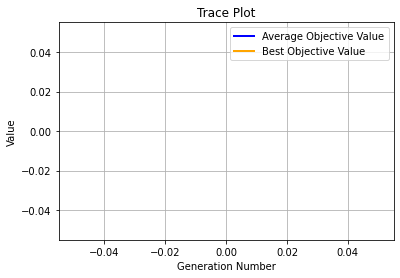

Execution time: 7.482278823852539 s
Evaluation number: 100000
Optimization fail: Could not find any feasible solution.


In [19]:
# single target function
@ea.Problem.single
def evalVars(Vars):
    f = np.sum(Vars * nbv[:1000]) # target functoin
    CV = np.array([
        np.sum(Vars * nbv[:1000]) - maxTotalNbv,
        -np.sum(Vars * nbv[:1000]) + minTotalNbv,
        np.sum(Vars * cost[:1000]) - maxTotalCost,
#         -np.sum(Vars * cost) + minTotalCost
    ])
    return f, CV

problem = ea.Problem(name='soea quick start demo',
                        M=1,  # 目标维数
                        maxormins=[1],  # 目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标
                        Dim=1000,  # 决策变量维数
                        varTypes=[0 for _ in range(1000)],  # 决策变量的类型列表，0：实数；1：整数
                        lb=[0 for _ in range(1000)], # low bound
                        ub=[1 for _ in range(1000)], # up bound
                        evalVars=evalVars)
# 构建算法
algorithm = ea.soea_SEGA_templet(problem,
                                    ea.Population(Encoding='RI', NIND=100),
                                    MAXGEN=1000,  # 最大进化代数。
                                    logTras=10,  # 表示每隔多少代记录一次日志信息，0表示不记录。
                                    trappedValue=1e-6,  # 单目标优化陷入停滞的判断阈值。
                                    maxTrappedCount=100)  # 进化停滞计数器最大上限值。
# 求解
res = ea.optimize(algorithm, seed=1, verbose=True, drawing=1, outputMsg=True, drawLog=False, saveFlag=True, dirName='result')

